![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/Influxdb_logo.svg/2560px-Influxdb_logo.svg.png "Influx")

***

**INFLUX DB = Open-Source Datenbank für Zeitreihen**

Hilfreiche Ressourcen:

[Dokumentation](https://docs.influxdata.com/influxdb/v2.0/)

[Python Client Library](https://docs.influxdata.com/influxdb/v2.0/api-guide/client-libraries/python/)

**Was ist das Spezielle an der Influx DB?**

* Eigene Query Language, ähnlich zu SQL
* Speichert die Einträge mit Zeitsstempeln
* kann große Mengen an Daten verarbeiten
* Besonders geeignet für z.B. Sensordaten
* Das User Interface bietet umfangreiche Möglichkeiten zur Visualisierung der Datenreihen

**Zu welcher Kategorie gehört die Datenbank?**

Zeitreihe

Datenpunkte bestehen aus Key-Value Paaren: field und timestamp
Datenpunkte können mittels Tags zu einer Serie zusammengefasst werden

**Lizenzen**

* Open Source Version als Download
* Kostenpflichtige Version gehostet auf AWS Cloud
* Kostenpflichtige Enterprise Version mit Zusatzleistungen

**Technische Eckdaten**

* Port 8060 für Client/Server Kommunikation
* Port 8088 für RPC Dienst (Datensicherung/Wiederherstellung)
* Einsatz eines Zeitdienstes notwendig (z.B. NTP - Network Time Protocol)
* Programmiert in Go
* Werte: 64-bit Integers, Floats, Strings und Booleans


**INFLUX DB Structure:**

In [1]:
json_body = [
    {
        "measurement": "your-measurement",
        "tags": {
            "tag1": "x",
            "tag2": "y"
        },
        "time": "2009-11-10T23:00:00Z",
        "fields": {
            "value": 0.64
        }
    }
]

**INFLUX DB User Interface**

![alt text](https://www.influxdata.com/wp-content/uploads/Pre-canned-dashboards-influxdb.png "Influx UI")




---

## Installation

[Hier](https://docs.influxdata.com/influxdb/v2.0/install/) gibt es eine genaue Anleitung für die Datenbankinstallation für verschiedene Umgebungen.

[Hier](https://github.com/simongavris/BIC-BB-5-InfluxDB-Demo/tree/master/notebooks) kannst du die InfluxDB unkompliziert über Docker installieren. Du findest hier auch dieses Notebook und eine Anleitung zur Installation mit Docker.

***

## Quickstart Guide

Für die Nutzung der Datenbank benötigen wir:

* Token zur Authentifizierung -> [Anleitung zur Tokenerstellung](https://docs.influxdata.com/influxdb/cloud/security/tokens/create-token/)

* Bucket als Speicherort unserer Daten -> [Anleitung zur Bucketerstellung](https://docs.influxdata.com/influxdb/cloud/organizations/buckets/create-bucket/) 

* Die Organisation, der der Bucket zugeordnet wird

*Die Erstellung von Buckets, Tokens und mehr kann über das User Interface, die Influx Command Line oder die InfluxDB API gemacht werden. Zum Einstieg empfehlen wir das UI.*

***

## Nutzung von Influx DB mit Python

#### Dependencies

In [3]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install influxdb-client

Defaulting to user installation because normal site-packages is not writeable


#### Initialize the Influx client

In [4]:
from datetime import datetime
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS

# Siehe "Quickstart Guide"
token = "EKOBZJQJ7m-CTLai4-otjUADp-trYaBgEp5gq62KyHW8LXMSnGKZIVFIxLYG6czs_F2FjIMzdBQjDqHy23I-jQ=="
org = "FHTW"
bucket = "Data"

client = InfluxDBClient(url="http://influxdb:8086", token=token)

#### Get some data

As an example, we want to stream some weather data from the API [Openweathermap](https://api.openweathermap.org) into our database, so we make a request to that API to get the current temperature in Vienna.

In [46]:
import requests, json

BASE_URL = "https://api.openweathermap.org/data/2.5/weather?"
API_KEY = "366c7011faf41711486e730d3a46e9c7"

def get_temp(city):
    
    URL = BASE_URL + "q=" + city + "&appid=" + API_KEY + "&units=metric"
    # HTTP request
    response = requests.get(URL)
    # checking the status code of the request
    if response.status_code == 200:
        # getting data in the json format
        data = response.json() 
        main = data["main"] 
        # getting temperature
        temperature = main['temp']
    else:
       # showing the error message
       print("Error in the HTTP request")
    return temperature


#### Write the data into the DB

*Now we want to write the current temperature into our Influx database and create a time series to monitor the temperature changes.
Here we show you 2 options: manual insert via line protocol and insert via a function*

The **InfluxDB line protocol** is a text-based format for writing points to the database. 

Points must be in line protocol format for InfluxDB to successfully parse and write points.

[Here](https://docs.influxdata.com/influxdb/v1.8/write_protocols/line_protocol_tutorial/) is more information about the line protocol and how to use it

***

The InfluxDBClient object has a `write_api` method used for configuration:

In [6]:
write_api = client.write_api(write_options=SYNCHRONOUS)

***

A `point` represents a single data record, similar to a row in a SQL database table. Each point:

* has a measurement, a tag set, a field key, a field value, and a timestamp;
* is uniquely identified by its series and timestamp.
* In a series, each point has a unique timestamp. If you write a point to a series with a timestamp that matches an existing point, the field set becomes a union of the old and new field set, where any ties go to the new field set.

***

In [21]:
#line protocol:

point = "weatherdata,country=Austria,city=Vienna temperature=23"
write_api.write(bucket=bucket, org=org, record=point)

#todo: show chronograph

In [47]:
#function to stream values into the database using an easier-to-read style

import time
from random import randrange
def stream(interval):
    while True:
        
        #get temperature from the API (here we add some random values for the visualization)
        temp_vienna = get_temp('Vienna') + randrange(-3,3)
        temp_berlin = get_temp('Berlin') + randrange(-3,3)

        
        #create new data point
        point_vienna = Point("weatherdata").tag('country','Austria').tag("city", "Vienna").field("temperature", temp_vienna).time(datetime.utcnow(), WritePrecision.S)
        point_berlin = Point("weatherdata").tag('country','Austria').tag("city", "Vienna").field("temperature", temp_berlin).time(datetime.utcnow(), WritePrecision.S)

        #write datapoint into database
        write_api.write(bucket=bucket, org=org, record=[point_vienna, point_berlin])
        
        #wait
        time.sleep(interval)

In [18]:
# Let's go! Write the temperature into the database every 3 seconds.
stream(3)

KeyboardInterrupt: 

#### Query our data

In [50]:
# 1. Instantiate the query client.
query_api = client.query_api()

# 2. Create a Flux query.
query = 'from(bucket:"Data")\
|> range(start: -10h)\
|> filter(fn:(r) => r._measurement == "weatherdata")'

# 3. Query the data
result = query_api.query(org=org, query=query)

# not much to do with it yet
print(result)

[<FluxTable: 10 columns, 722 records>, <FluxTable: 10 columns, 722 records>]


In [51]:
# 4. Put data into a matrix
results = []
for table in result:
    for record in table.records:
        results.append((record.get_time(), record.get_field(), record.get_value()))

print(results)

[(datetime.datetime(2021, 9, 22, 14, 4, tzinfo=tzlocal()), 'temperature', 17.11), (datetime.datetime(2021, 9, 22, 14, 4, 4, tzinfo=tzlocal()), 'temperature', 17.11), (datetime.datetime(2021, 9, 22, 14, 4, 7, tzinfo=tzlocal()), 'temperature', 18.11), (datetime.datetime(2021, 9, 22, 14, 4, 11, tzinfo=tzlocal()), 'temperature', 19.11), (datetime.datetime(2021, 9, 22, 14, 4, 14, tzinfo=tzlocal()), 'temperature', 16.11), (datetime.datetime(2021, 9, 22, 14, 4, 18, tzinfo=tzlocal()), 'temperature', 15.11), (datetime.datetime(2021, 9, 22, 14, 4, 21, tzinfo=tzlocal()), 'temperature', 16.11), (datetime.datetime(2021, 9, 22, 14, 4, 24, tzinfo=tzlocal()), 'temperature', 16.11), (datetime.datetime(2021, 9, 22, 14, 4, 28, tzinfo=tzlocal()), 'temperature', 17.11), (datetime.datetime(2021, 9, 22, 14, 4, 31, tzinfo=tzlocal()), 'temperature', 20.11), (datetime.datetime(2021, 9, 22, 14, 4, 35, tzinfo=tzlocal()), 'temperature', 20.11), (datetime.datetime(2021, 9, 22, 14, 4, 38, tzinfo=tzlocal()), 'tempera

In [54]:
from pandas import *

DataFrame(results)

,0,1,2
0,2021-09-22 14:04:00+00:00,temperature,17.11
1,2021-09-22 14:04:04+00:00,temperature,17.11
2,2021-09-22 14:04:07+00:00,temperature,18.11
3,2021-09-22 14:04:11+00:00,temperature,19.11
4,2021-09-22 14:04:14+00:00,temperature,16.11
...,...,...,...
1439,2021-09-22 15:57:01+00:00,temperature,11.92
1440,2021-09-22 15:57:05+00:00,temperature,12.92
1441,2021-09-22 15:57:09+00:00,temperature,10.92
1442,2021-09-22 15:57:13+00:00,temperature,10.92


In [55]:
import numpy as np

print(np.matrix(results))

[[datetime.datetime(2021, 9, 22, 14, 4, tzinfo=tzlocal()) 'temperature'
  17.11]
 [datetime.datetime(2021, 9, 22, 14, 4, 4, tzinfo=tzlocal())
  'temperature' 17.11]
 [datetime.datetime(2021, 9, 22, 14, 4, 7, tzinfo=tzlocal())
  'temperature' 18.11]
 ...
 [datetime.datetime(2021, 9, 22, 15, 57, 9, tzinfo=tzlocal())
  'temperature' 10.92]
 [datetime.datetime(2021, 9, 22, 15, 57, 13, tzinfo=tzlocal())
  'temperature' 10.92]
 [datetime.datetime(2021, 9, 22, 15, 57, 16, tzinfo=tzlocal())
  'temperature' 11.92]]


### Easier solution: query data directly to a pandas dataframe

In [57]:
result_df = query_api.query_data_frame(org=org, query=query)
result_df

,result,table,_start,_stop,_time,_value,_field,_measurement,city,country
0,_result,0,2021-09-22 06:09:19.827921+00:00,2021-09-22 16:09:19.827921+00:00,2021-09-22 14:04:00+00:00,17.11,temperature,weatherdata,Berlin,Germany
1,_result,0,2021-09-22 06:09:19.827921+00:00,2021-09-22 16:09:19.827921+00:00,2021-09-22 14:04:04+00:00,17.11,temperature,weatherdata,Berlin,Germany
2,_result,0,2021-09-22 06:09:19.827921+00:00,2021-09-22 16:09:19.827921+00:00,2021-09-22 14:04:07+00:00,18.11,temperature,weatherdata,Berlin,Germany
3,_result,0,2021-09-22 06:09:19.827921+00:00,2021-09-22 16:09:19.827921+00:00,2021-09-22 14:04:11+00:00,19.11,temperature,weatherdata,Berlin,Germany
4,_result,0,2021-09-22 06:09:19.827921+00:00,2021-09-22 16:09:19.827921+00:00,2021-09-22 14:04:14+00:00,16.11,temperature,weatherdata,Berlin,Germany
...,...,...,...,...,...,...,...,...,...,...
1439,_result,1,2021-09-22 06:09:19.827921+00:00,2021-09-22 16:09:19.827921+00:00,2021-09-22 15:57:01+00:00,11.92,temperature,weatherdata,Vienna,Austria
1440,_result,1,2021-09-22 06:09:19.827921+00:00,2021-09-22 16:09:19.827921+00:00,2021-09-22 15:57:05+00:00,12.92,temperature,weatherdata,Vienna,Austria
1441,_result,1,2021-09-22 06:09:19.827921+00:00,2021-09-22 16:09:19.827921+00:00,2021-09-22 15:57:09+00:00,10.92,temperature,weatherdata,Vienna,Austria
1442,_result,1,2021-09-22 06:09:19.827921+00:00,2021-09-22 16:09:19.827921+00:00,2021-09-22 15:57:13+00:00,10.92,temperature,weatherdata,Vienna,Austria


#### Quick analysis: filter for vienna and plot

<AxesSubplot:xlabel='_time'>

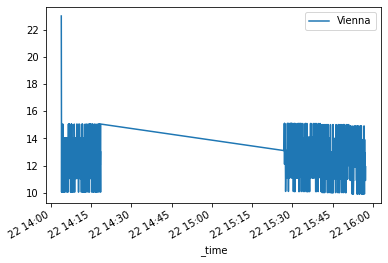

In [65]:
result_df[result_df.city == 'Vienna'].plot.line(y='_value', x='_time', label='Vienna')

### Flux queries

In [75]:
query = 'from(bucket:"Data")\
|> range(start: -30m)\
|> timedMovingAverage(every: 10s, period: 30s) \
|> filter(fn: (r) => r.city == "Vienna")'

result_df_ma = query_api.query_data_frame(org=org, query=query)

result_df_ma

,result,table,_start,_stop,_field,_measurement,city,country,_value,_time
0,_result,0,2021-09-22 15:44:46.767836+00:00,2021-09-22 16:14:46.767836+00:00,temperature,weatherdata,Vienna,Austria,13.020000,2021-09-22 15:44:50+00:00
1,_result,0,2021-09-22 15:44:46.767836+00:00,2021-09-22 16:14:46.767836+00:00,temperature,weatherdata,Vienna,Austria,11.686667,2021-09-22 15:45:00+00:00
2,_result,0,2021-09-22 15:44:46.767836+00:00,2021-09-22 16:14:46.767836+00:00,temperature,weatherdata,Vienna,Austria,12.186667,2021-09-22 15:45:10+00:00
3,_result,0,2021-09-22 15:44:46.767836+00:00,2021-09-22 16:14:46.767836+00:00,temperature,weatherdata,Vienna,Austria,12.270000,2021-09-22 15:45:20+00:00
4,_result,0,2021-09-22 15:44:46.767836+00:00,2021-09-22 16:14:46.767836+00:00,temperature,weatherdata,Vienna,Austria,12.395000,2021-09-22 15:45:30+00:00
...,...,...,...,...,...,...,...,...,...,...
73,_result,0,2021-09-22 15:44:46.767836+00:00,2021-09-22 16:14:46.767836+00:00,temperature,weatherdata,Vienna,Austria,13.045000,2021-09-22 15:57:00+00:00
74,_result,0,2021-09-22 15:44:46.767836+00:00,2021-09-22 16:14:46.767836+00:00,temperature,weatherdata,Vienna,Austria,12.295000,2021-09-22 15:57:10+00:00
75,_result,0,2021-09-22 15:44:46.767836+00:00,2021-09-22 16:14:46.767836+00:00,temperature,weatherdata,Vienna,Austria,11.920000,2021-09-22 15:57:20+00:00
76,_result,0,2021-09-22 15:44:46.767836+00:00,2021-09-22 16:14:46.767836+00:00,temperature,weatherdata,Vienna,Austria,11.720000,2021-09-22 15:57:30+00:00


<AxesSubplot:xlabel='_time'>

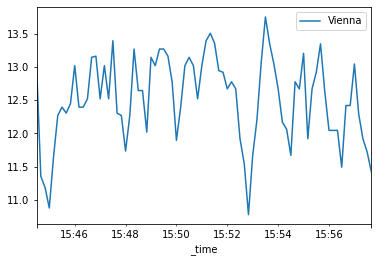

In [74]:
result_df_ma.plot.line(y='_value', x='_time', label='Vienna')

***

## Wann ist ein Einsatz sinnvoll?

**Wenn Echtzeitverarbeitung von Daten notwendig ist**

**Bei großen Datenmengen und hoher Geschwindigkeit**

*Beispiele:*

   * Monitoring von IoT / Sensoren
   * DevOps Monitoring (Mikroservices, Container, Ressourcenverwaltung, Netzwerke,...)
   * Echtzeit-Analysen (z.B. Onlinemarketing, Predicitive Maintenance,...)

## InfluxDB: Tick Stack

* **T**elegraf: Agent zum Sammeln, Verarbeiten, Zusammenführen und Schreiben von Metriken und schreiben in die InfluxDB
* **I**nfluxDB: Zeitreihenbasierte Datenbank (NoSQL)
* **C**hronograf: Grafische Benutzeroberfläche zur Datenbank
* **K**apacitor: Echtzeitschnittstelle zur Datenbank 

![](https://www.influxdata.com/wp-content/uploads/Influx-1.0-Diagram.png)
